In [1]:
import geopandas as gpd
from engine import *
from tqdm import tqdm


In [2]:
### Cargamos datos
agebs = gpd.read_file("agebs_ZM_de_Querétaro.geojson")
## Calculamos el centroide de cada ageb
agebs["centroide"] = agebs["geometry"].centroid


/home/milo/miniconda3/envs/crecurb/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


<AxesSubplot:>

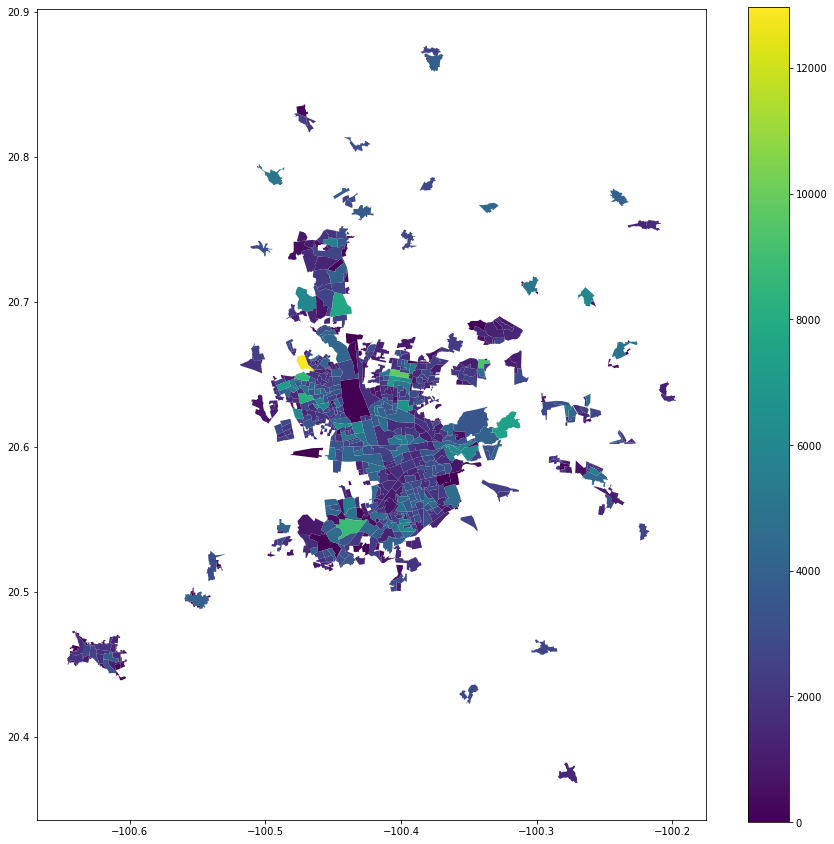

In [3]:
### Vemos el mapa
agebs.plot(column='POBTOT',figsize=(15, 15), legend=True)

In [71]:
### Observamos las primeras 20 columnas
agebs['PRESOE15']=agebs['PRESOE15'].apply(lambda x : float(str(x).replace("*","1.5")))


In [5]:

## Obtenemos la matriz de adjacencia de los vecinos de los agebs
print("%-------------------------------------------------------------%")
print("Obtenemos la matriz de adjacencia de los vecinos de los agebs")
print("%--------------------------------------------------------------%")

adyacencia_dic = layer2net(agebs)


  0%|          | 0/666 [00:00<?, ?it/s]

%-------------------------------------------------------------%
Obtenemos la matriz de adjacencia de los vecinos de los agebs
%--------------------------------------------------------------%


100%|██████████| 666/666 [00:42<00:00, 15.67it/s]


In [11]:
np.array([adyacencia_dic[i] for i in adyacencia_dic.keys()])
import pickle

with open('adyacencia_dic.pickle', 'wb') as handle:
    pickle.dump(adyacencia_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [13]:
with open('adyacencia_dic.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [72]:
### Definimos las clases y sus atributos
class Ageb:
    def __init__(self,cvegeo,poblacion,geometria,vivienda,inmigrantes,centroide):
        self.cvegeo = cvegeo
        self.poblacion = {0 : poblacion}
        self.vivienda = {0 : vivienda}
        self.inmigrantes = {0 : inmigrantes}
        self.densidad_poblacional = {}
        self.vecinos = []
        self.geometria  = geometria
        self.centroide = centroide
        self.proba_ocupacion_inicial = {"juriquilla" : 0,"pi_bj" : 0,'elpueblito':0}
        self.proba_ocupacion_min = 0
        self.distancia_vecino = {}
        self.ruta_vecino = {}
        self.distancias_cbd = {"juriquilla" : 0,"pi_bj" : 0,'elpueblito':0}
        self.distancias_min_cbd = 0

class Network:
    def __init__(self):
        self.agebs ={}


In [74]:
# Instancia de la clase Network()
agebs_net = Network()

# Agregamos las instancias de cada ageb en el diccionacio de agebs_net
print("%-------------------------------------------------------------%")
print("Agregamos las instancias de cada ageb en el diccionacio de agebs_net")
print("%--------------------------------------------------------------%")
for ageb in tqdm(list(adyacencia_dic.keys())):
    poblacion = agebs[agebs["CVEGEO"]==ageb]["POBTOT"].item()
    geometria = agebs[agebs["CVEGEO"]==ageb]["geometry"].item()
    vivtot = agebs[agebs["CVEGEO"]==ageb]["VIVTOT"].item()
    inmigrantes = agebs[agebs['CVEGEO']==ageb]["PRESOE15"].item() 
    centroide = agebs[agebs["CVEGEO"]==ageb]["centroide"].item()
    agebs_net.agebs[ageb]=Ageb(ageb,poblacion,geometria,vivtot,inmigrantes,centroide)

# Agregamos los vecinos de cada ageb
print("%-------------------------------------------------------------%")
print("Agregamos los vecinos de cada ageb")
print("%--------------------------------------------------------------%")
for ageb in tqdm(list(adyacencia_dic.keys())):
    lista_vecinos = list(np.where((adyacencia_dic[ageb]==1))[0])
    ref_vecinos = []

    if len(lista_vecinos)==0:
        pass
    else:
        for vecino in np.take(list(agebs_net.agebs.keys()),lista_vecinos):
            ref_vecinos.append(agebs_net.agebs[vecino])
        agebs_net.agebs[ageb].vecinos=ref_vecinos


  1%|          | 6/666 [00:00<00:11, 56.14it/s]

%-------------------------------------------------------------%
Agregamos las instancias de cada ageb en el diccionacio de agebs_net
%--------------------------------------------------------------%


100%|██████████| 666/666 [00:00<00:00, 3701.70it/s]

%-------------------------------------------------------------%
Agregamos los vecinos de cada ageb
%--------------------------------------------------------------%


In [75]:
### Diccionario de principales destinos de trabajo
destinos = {"zocalo": (19.432229587797913, -99.13342540255914),
            "condesa" :(19.41500702816897, -99.17754326239348),
            "reforma" : (19.42631517782024, -99.19379876201027),
            "delValle": (19.373937627246054, -99.17861804875692),
            "viveros": (19.35420491791415, -99.17548474041028),
            "vallejo" : (19.49489893376003, -99.1647650982302),
            "cu": (19.322740688438223, -99.1866604705067),
            "polanco" : (19.433666445182244, -99.19094770204629),
            "santafe" : (19.361383705434182, -99.27367230390125)}

destinos_qro = {'juriquilla':(20.70328832963603, -100.45315166039546),
                'pi_bj': (20.63738283212626, -100.4281830983263),
                'elpueblito': (20.539299465897976, -100.4385583226433)}          

In [76]:
### Definimos función para calcular distancia geodésica
import geopy.distance

def get_distancias(origen,destino):
    origen = tuple(reversed(origen.centroide.coords[0]))
    dist = geopy.distance.geodesic(origen,destino)
    
    return dist.meters

### Ejemplo
get_distancias(agebs_net.agebs['220140001038A'], (20.63738283212626, -100.4281830983263))


6220.183210424338

In [77]:
### Obtenemos las distancias con respecto a los centros laborales 
for key_ageb,ageb in tqdm(agebs_net.agebs.items()):
    for k,v in destinos_qro.items():
        ageb.distancias_cbd[k]=get_distancias(ageb,v)
        
### Verificamos con un ageb
agebs_net.agebs['220140001038A'].distancias_cbd

100%|██████████| 666/666 [00:00<00:00, 915.87it/s] 


{'juriquilla': 13736.99935359061,
 'pi_bj': 6220.183210424338,
 'elpueblito': 7993.537314464885}

In [78]:
for key_ageb,ageb in tqdm(agebs_net.agebs.items()):
    ageb.distancias_min_cbd= min(ageb.distancias_cbd.values())

## Probamos
agebs_net.agebs['220140001038A'].distancias_min_cbd,agebs_net.agebs['220140001038A'].distancias_cbd

100%|██████████| 666/666 [00:00<00:00, 241748.72it/s]


(6220.183210424338,
 {'juriquilla': 13736.99935359061,
  'pi_bj': 6220.183210424338,
  'elpueblito': 7993.537314464885})

100%|██████████| 666/666 [00:00<00:00, 445306.31it/s]


<AxesSubplot:>

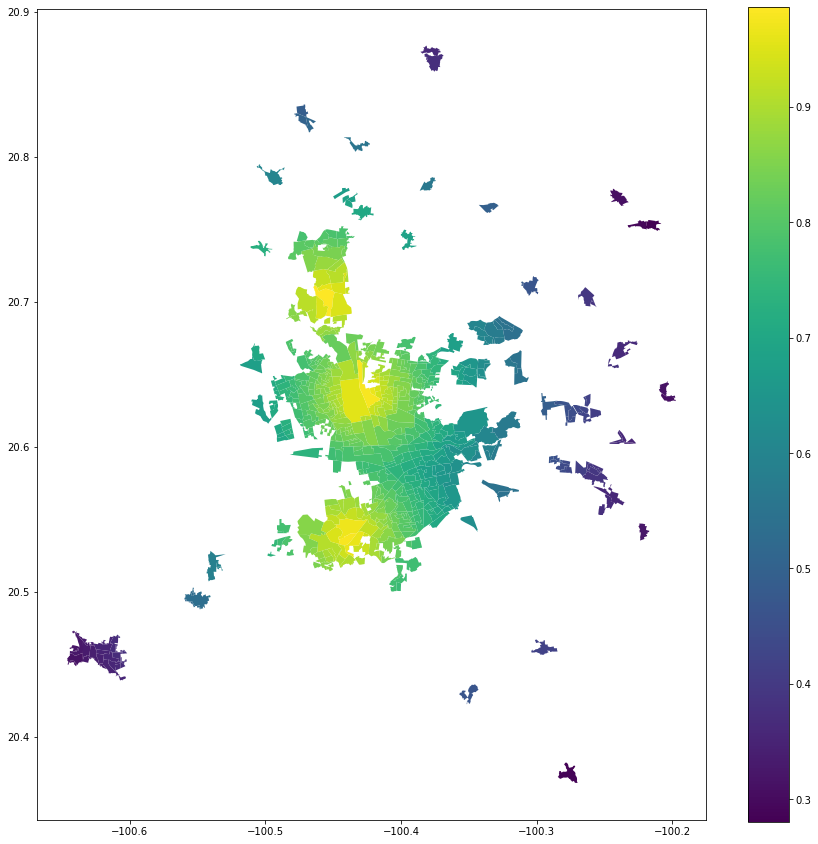

In [79]:
## Exponencial 1
### Calculamos la probabilidad inicial de cada ageb
b = 5

for key_ageb,ageb in tqdm(agebs_net.agebs.items()):
    r = ageb.distancias_min_cbd/100000
    ageb.proba_ocupacion_min=np.exp(-b*r)
#### Guardamos la probabilidad inicial con respecto juriquilla
proba_lista = []

for key_ageb,ageb in tqdm(agebs_net.agebs.items()):
    proba_lista.append(ageb.proba_ocupacion_min)
    
df = pd.DataFrame({"cvegeo":agebs['CVEGEO'],'proba_inicial': proba_lista,"geometry":agebs['geometry']})
gdf = gpd.GeoDataFrame(df, geometry='geometry')

gdf.plot(column='proba_inicial',figsize=(15, 15), legend=True)

100%|██████████| 666/666 [00:00<00:00, 542303.72it/s]


<AxesSubplot:>

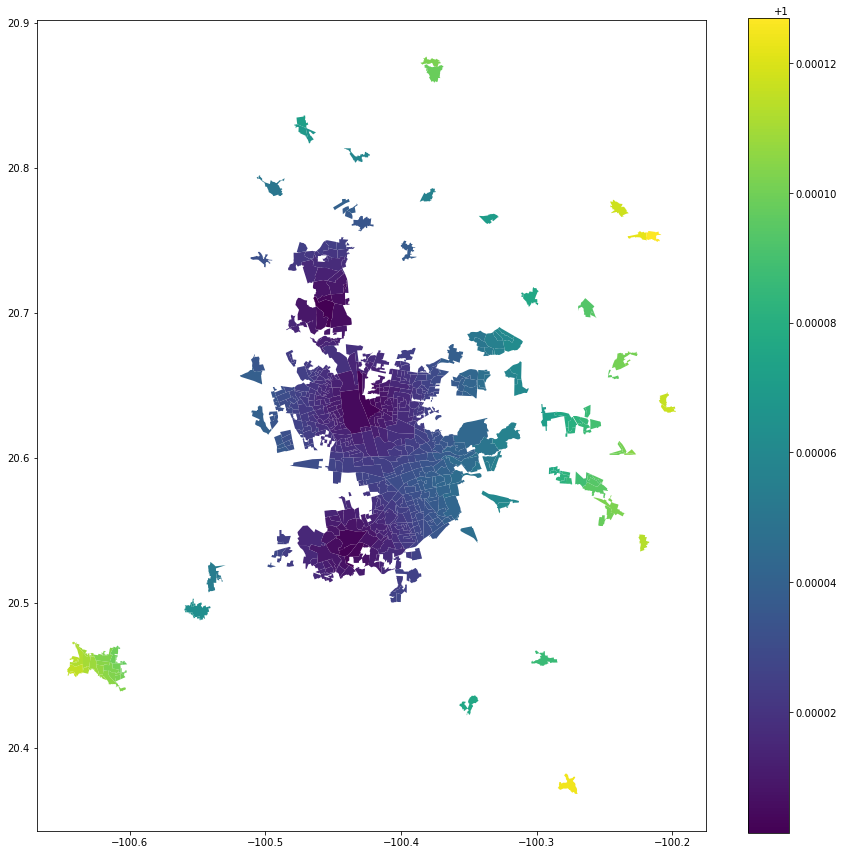

In [80]:
## Exponencial 2
### Calculamos la probabilidad inicial de cada ageb
b = 0.005
c = 0.0002
for key_ageb,ageb in tqdm(agebs_net.agebs.items()):
    r = ageb.distancias_min_cbd/1000000
    ageb.proba_ocupacion_min=np.exp(b*r-c*r**2) 
ageb.proba_ocupacion_min

#### Guardamos la probabilidad inicial con respecto juriquilla
proba_lista = []

for key_ageb,ageb in tqdm(agebs_net.agebs.items()):
    proba_lista.append(ageb.proba_ocupacion_min)
    
df = pd.DataFrame({"cvegeo":agebs['CVEGEO'],'proba_inicial': proba_lista,"geometry":agebs['geometry']})
gdf = gpd.GeoDataFrame(df, geometry='geometry')

gdf.plot(column='proba_inicial',figsize=(15, 15), legend=True)

$\textbf{Modelo de crecimiento}$

Dado el AGEB $i$, con población $P_i$ y número de viviendas $V_i$, su densidad poblacional esta dada por

$$\rho_i=\frac{P_i}{V_i}.$$

La población puede crecer siguiendo un modelo logístico discreto

$$P_i(t)=\frac{K}{1+Ae^{-k(t)}},$$

con 

$$A=\frac{K-P_0}{P_0},$$

tasa de crecimiento $k\in\mathbb{R}$, y capacidad de carga $K\in\mathbb{R}$.

$\sigma_i,k\in\mathbb{R}$, o un crecimiento proporcional a la población
$$P_i(t+1)=P_i(t)+P_i(t)\delta,$$

con $\delta\in[0,\delta_{\text{max}}]$, un número aleatorio escogido siguiendo una distribución normal y $\delta_{\text{max}}\in\{1,2\}$.

La vivienda puede aumentar de manera constante
$$V_i(t+1)=V_i(t)+c.$$

con $c\in\mathbb{N}$. 

Text(0, 0.5, 'Población')

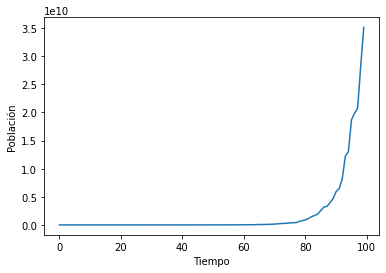

In [60]:
import matplotlib.pyplot as plt 

def logistico_cont(p_i,k,K,t):
    A=(K-p_i)/p_i
    P=K/(1+A*np.exp(-k*t))
    return P 



T=100
#r=4
k=0.1
K=5000

## La población de todos los agebs crece al 2% por 10 periodos
for t in range(10):
    print(t)
    for ageb in agebs_net.agebs:
        rand=np.random.uniform(0.1,0.9)
        agebs_net.agebs[ageb].poblacion[t]=agebs_net.agebs[ageb].poblacion[t]+agebs_net.agebs[ageb].inmigrantes[t] 
        
        agebs_net.agebs[ageb].poblacion[t+1] = (1+.002)*agebs_net.agebs[ageb].poblacion[t] 
        
    
        
    t=i
    p_i=logistico_cont(p_i,k,K,t)
    l[i]=p_i

plt.plot(l) 
min(l)
plt.xlabel('Tiempo')
plt.ylabel('Población') 

In [ ]:
n=30
b=0.5
p_oei=np.zeros((n,n))
for i in range(n):
    for j in range(n): 
    #distancia al centro
    r=dist[i][j]
    p_oei[i][j]=np.exp(-b*r)
    
p_oei=p_oei/np.sum(p_oei) 

In [ ]:
## Pensemos que la población en este ageb crece en 2%
for t in range(10):
    agebs_net.agebs['220140001038A'].poblacion[t+1]= (1+0.02) * agebs_net.agebs['220140001038A'].poblacion[t]
    
agebs_net.agebs['220140001038A'].poblacion

In [ ]:
## Observamos información de los vecinos de un ageb
for vecino in agebs_net.agebs['220140001038A'].vecinos:
    print("El ageb de 220140001038A con población {} tiene por vecino a la ageb {} con población {}".format(agebs_net.agebs['220140001038A'].poblacion[0],vecino.cvegeo,vecino.poblacion[0]))

In [75]:
## La población de todos los agebs crece al 2% por 10 periodos
for t in range(10):
    print(t)
    for ageb in agebs_net.agebs:
        agebs_net.agebs[ageb].poblacion[t+1] = (1+.002)*agebs_net.agebs[ageb].poblacion[t] 
agebs_net.agebs['1100400010737'].poblacion

0
1
2
3
4
5
6
7
8
9


{0: 8,
 1: 8.016,
 2: 8.032032,
 3: 8.048096064,
 4: 8.064192256127999,
 5: 8.080320640640256,
 6: 8.096481281921536,
 7: 8.11267424448538,
 8: 8.128899592974351,
 9: 8.1451573921603,
 10: 8.161447706944621}